This is about loading data in TensorFlow
https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/

1. Saving data in the TensorFlow format .tfrecords
2. Trying to load 1 example
3. Building a shuffling queue

In [1]:
# Load dataset
import numpy as np, tensorflow as tf, cPickle
from tqdm import tqdm

def unpickle(fn):
    fo = open(fn, 'rb'); dict = cPickle.load(fo); fo.close();
    return dict

def loadRawData():
    training = np.zeros((50000, 3072)); training_labels = np.zeros(50000)
    for i in range(5):
        d = unpickle("cifar10/data_batch_"+str(i+1))
        training[10000*i:(10000*(i+1)), :] = d['data']
        training_labels[np.arange(10000*i, (10000*(i+1)))] = np.array(d['labels'], dtype='int32')
        
    d = unpickle("cifar10/test_batch"); test = d['data']
    test_labels = np.array(d['labels']);

    return training, training_labels, test, test_labels

def writeTfRecords(imgs, labels, fn='cifar10.tfrecords'):
    
    writer = tf.python_io.TFRecordWriter(fn)
    for i in tqdm(range(len(imgs))):
        example = tf.train.Example(
            features = tf.train.Features(
                feature={'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[labels[i].astype("int64")])),
                         'image': tf.train.Feature(int64_list=tf.train.Int64List(value=imgs[i].astype("int64")))
                        }
            )
        )
        serialized = example.SerializeToString()
        writer.write(serialized)

training, training_labels, test, test_labels = loadRawData()
# writeTfRecords(training, training_labels, 'cifar10.tfrecords')
writeTfRecords(test, test_labels, 'cifar10_test.tfrecords')

100%|██████████| 10000/10000 [01:02<00:00, 159.56it/s]


In [38]:
import tensorflow as tf, matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.5, 4) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

filename = "cifar10.tfrecords"
o = 0
for serialized_example in tf.python_io.tf_record_iterator(filename):
    example = tf.train.Example()
    example.ParseFromString(serialized_example)

    # traverse the Example format to get data
    image = np.array(example.features.feature['image'].int64_list.value, dtype='float32').reshape((3,32,32)).transpose((1,2,0))
    image /= 255.0
    label = example.features.feature['label'].int64_list.value[0]
    plt.title(label_names[label])
    plt.imshow(image)
    o += 1
    if o > 7:
        break

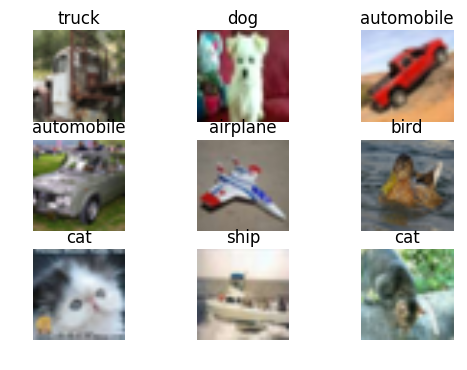

In [5]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np

%matplotlib inline

def read_and_decode_single_cifar10(filename, epochs=None):
    filename_queue = tf.train.string_input_producer([filename], num_epochs=epochs)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example, features={
            'label': tf.FixedLenFeature([], tf.int64), 'image': tf.FixedLenFeature([3072], tf.int64)
        })
    # now return the converted data
    image = tf.reshape(features['image'], [3, 32, 32])
    image = tf.cast(tf.transpose(image, [1,2,0]), tf.float32) / 255.0
    label = features['label']
    label = tf.one_hot(label, 10, on_value=1, off_value=0)
    return label, image

batch_size = 9

label, image = read_and_decode_single_cifar10("cifar10.tfrecords", None)
label_batch, image_batch = tf.train.shuffle_batch([label, image], batch_size=batch_size, capacity=2000, min_after_dequeue=1000)

label_names = unpickle('cifar10/batches.meta')['label_names']

sess = tf.Session()
init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

label_batch1, image_batch1 = sess.run([label_batch, image_batch])

fig = plt.figure()
for i in range(batch_size):
    ax = fig.add_subplot(3,3,i+1); ax.axis('off')
    img = np.array(image_batch1[i], dtype='float32')
    ax.set_title(label_names[np.argmax(label_batch1[i])])
    ax.imshow(img)

plt.show()
